<a href="https://colab.research.google.com/github/davetew/Modern-Aerospace-Propulsion/blob/main/Homework_2_Turbojet_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework #2 - Turbojet Optimization

1) In lecture #3, we derived a simplified expression for the dimensionless specific thrust () given a number of assumed parameters--

Flight Mach number ()
Ambient static temperature ()
Fuel lower heating value ()
Compressor isentropic efficiency ()
Turbine isentropic efficiency ()
Combustor fuel to air mass flow ratio ()
Compressor pressure ratio ()
At the end of lecture, we discussed which two of these were truly design optimization parameters from a cycle perspective --  and .  Also we discussed the importance of restricting the turbine inlet temperature ( ) to a level that won't result in turbine damage (e.g., melting 🫠).

Given the above, please optimize the design of your turbojets (by varying  and  for compressor and turbine efficiencies of 90%) to maximize the overall efficiency at several flight Mach numbers between 0.5 and 2.0 at an altitude of 35,000 feet (=219K).

I recommend starting with the "SimpleTurboJet" python class that I have saved toward the bottom of the Colab notebook at this link on Github, checking that you are okay with it, and implementing an optimization routine as an internal method or external function using SciPy minimize.  However, please feel free to use any numerical approach that you prefer.

In your optimization, please constrain the turbine inlet total temperature () to be less than 1800K -- at each of the flight Mach numbers.  Also, please bound the fuel to air ratio () to ensure that you don't add more fuel than the stoichiometric limit (e.g., 0 < f < 0.067 for Jet-A/Air combustion).

Please plot the dimensionless specific thrust, overall efficiency,  and  versus flight Mach number.

2) Please update the analytical turbojet specific thrust expression that we derived in class to include a post-turbine afterburner with a second fuel to air ratio.  Feel free to implement it in another python class, and plot the efficiency and dimensionless specific thrust to help see if you are correct; however, this is not required.  If you do, remember that the combined burner and after-burner fuel to air ratio must be less than the stoichiometric fuel to air ratio (i.e., ).

Please let me know if you have any questions!!!








In [ ]:
# Import the required python packages
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # Mac retina display resolution for plots

# Set matplotlib text sizes that are appropriate for a presentation
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 14,
})

from typing import Union, List, Tuple, Dict, Callable, Optional, Any, Literal

from scipy.optimize import minimize
import pandas as pd

In [ ]:
# Compressible Flow Relations

# Convenient Function of the Ratio of Specific Heats
ga1 = lambda ga: ga / (ga - 1)

# Total to static temperature ratio
theta = lambda M, ga: 1 + (ga-1)/2*M**2

# Total to static pressure ratio
delta = lambda M, ga: theta(M, ga)**ga1(ga)


In [99]:
class SimpleTurbojet():

  # Air properties
  ga = 1.4
  ga1 = ga / (ga-1)
  R_air = 287.05 # J/kg/K
  cp_air = ga / (ga-1) * R_air # J/kg/K

  def __init__(self, M_inf: float = 0.8, eta_comp: float = 1.0,
               eta_turb: float = 1.0, pi_comp: float = 50,
               f: float = 0.025, LHV_f: float = 43.7, T_inf_K: float = 273) -> None:
    """Initialized an instance of the Turbojet class given
    M_inf - float: Flight Mach Number
    eta_c - float: Compressor isentropic efficiency
    eta_t - float: Turbine isentropic efficiency
    pi_c - float: Compressor total presssure ratio
    f - float: Fuel air ratio
    LHV_f - float: Lower heating value of the fuel in MJ/kg"""
    self.M_inf = M_inf
    self.eta_comp = eta_comp
    self.eta_turb = eta_turb
    self.pi_comp = pi_comp
    self.f = f
    self.LHV_f = LHV_f * 1e6 # Convert MJ/kg to J/kg
    self.T_inf_K = T_inf_K

  @property
  def tau_comp(self) -> float:
    """Compresssor total temperature ratio"""
    return 1 + (self.pi_comp**(1/self.ga1) - 1)/self.eta_comp

  @property
  def tau_burner(self) -> float:
    """Burner total temperature ratio"""
    #Tt_inf = self.T_inf_K / theta(self.M_inf, self.ga)
    Tt_inf = self.T_inf_K * theta(self.M_inf, self.ga)
    return 1 + 1 / self.tau_comp * self.f * self.LHV_f / self.cp_air / Tt_inf

  @property
  def tau_turb(self) -> float:
    """Turbine total temperature ratio"""
    return 1 - (self.tau_comp - 1)/self.tau_burner/self.tau_comp

  @property
  def T4_K(self) -> float:
    """Turbine inlet temperature"""
    return self.T_inf_K * theta(self.M_inf, self.ga) * self.tau_comp * self.tau_burner

  @property
  def pi_turb(self) -> float:
    """Turbine total pressure ratio"""
    return (1 + (self.tau_turb - 1)/self.eta_turb)**self.ga1

  @property
  def M_exit(self) -> float:
    """Nozzle exit Mach number"""
    return np.sqrt(2/(self.ga-1)*((self.pi_turb*self.pi_comp)**(1/self.ga1)*theta(self.M_inf, self.ga) - 1))

  @property
  def thrust(self) -> float:
    """Dimensionless specific thrust"""
    return self.M_exit / self.M_inf * np.sqrt( theta(self.M_inf, self.ga)/theta(self.M_exit,self.ga) *
                                              self.tau_turb * self.tau_burner * self. tau_comp ) - 1

  @property
  def eta_overall(self) -> float:
    """Overall efficiency"""
    return self.thrust / self.f * self.M_inf**2 * self.ga * self.R_air * self.T_inf_K / self.LHV_f

  @property
  def design(self) -> pd.Series:
    """Return a summary of the turbojet design"""
    return pd.Series({"M_inf": self.M_inf,
                      "eta_comp": self.eta_comp,
                      "eta_turb": self.eta_turb,
                      "pi_comp": self.pi_comp,
                      "f": self.f,
                      "LHV_f": self.LHV_f})

  @property
  def performance(self) -> pd.Series:
    """Return a summary of the turbojet performance"""
    return pd.Series({"thrust": self.thrust,
                      "overall efficiency": self.eta_overall,
                      "tau_comp": self.tau_comp,
                      "tau_burner": self.tau_burner,
                      "tau_turb": self.tau_turb,
                      "pi_turb": self.pi_turb,
                      "M_exit": self.M_exit})

  def optimize(self, metric: Literal['efficiency', 'thrust'] = 'efficiency',
               max_turbine_inlet_temp_K: float = 1800, M_inf: Union[None, float] = None,
               initial_guess: Union[None, Tuple[float, float]] = None):
    """Optimize the turbojet design for the given metric by varying the
    fuel to air ratio and the compressor pressure ratio"""

    # Use the default Mach number if none is specified
    self.M_inf = self.M_inf if M_inf is None else M_inf

    # Save the original fuel to air ratio and compressor pressure ratio
    org_f, org_pi_comp = self.f, self.pi_comp

    def fX(X):
      """Function to minimize to optimize the turbojet design"""
      self.f, self.pi_comp = X
      if metric == 'efficiency':
        return -self.eta_overall
      else:
        return -self.thrust

    # Use the provided initial guess if available, otherwise use the current values
    initial_guess = initial_guess if initial_guess is not None else (self.f, self.pi_comp)

    # Define the constraint for turbine inlet temperature
    def turbine_inlet_temp_constraint(X):
        self.f, self.pi_comp = X
        return max_turbine_inlet_temp_K - self.T4_K

    # Define a specific thrust constraint
    def specific_thrust_constraint(X):
        self.f, self.pi_comp = X
        return self.thrust

    constraints = [{'type': 'ineq', 'fun': turbine_inlet_temp_constraint},
                   {'type': 'ineq', 'fun': specific_thrust_constraint}]

    result = minimize(fX, initial_guess, method='SLSQP', bounds=[(1e-3, 0.067), (1+1e-3, 50)],
                      constraints=constraints,
                      options={'maxiter': 10000, 'ftol': 1e-6}) # Increase max iterations

    if result.success:
      print(f'✅ Optimization succeeded: M_inf={self.M_inf}')
      print(f'  {metric}: {-result.fun}')
      self.f, self.pi_comp = result.x
      return True
    else:
      print(f"❌ Optimization failed: M_inf={self.M_inf}")
      self.f, self.pi_comp = org_f, org_pi_comp
      print(result.message)
      return False

<>:33: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-4058911783.py:33: SyntaxWarning: invalid escape sequence '\p'
  axy.set_ylabel('$\pi_{comp}$', color="blue")


✅ Optimization succeeded: M_inf=0.1
  efficiency: 0.16051163708073027
✅ Optimization succeeded: M_inf=0.1019019019019019
  efficiency: 0.16314771958811508
✅ Optimization succeeded: M_inf=0.10380380380380382
  efficiency: 0.16576956112927552
✅ Optimization succeeded: M_inf=0.10570570570570571
  efficiency: 0.16837723235385357
✅ Optimization succeeded: M_inf=0.10760760760760761
  efficiency: 0.17097080377478713
✅ Optimization succeeded: M_inf=0.10950950950950951
  efficiency: 0.17355034576617853
✅ Optimization succeeded: M_inf=0.11141141141141142
  efficiency: 0.17611592856118324
✅ Optimization succeeded: M_inf=0.11331331331331332
  efficiency: 0.1786676222499149
✅ Optimization succeeded: M_inf=0.11521521521521522
  efficiency: 0.18120549677737577
✅ Optimization succeeded: M_inf=0.11711711711711711
  efficiency: 0.18372962194140185
✅ Optimization succeeded: M_inf=0.11901901901901903
  efficiency: 0.18624006739062968
✅ Optimization succeeded: M_inf=0.12092092092092092
  efficiency: 0.1887

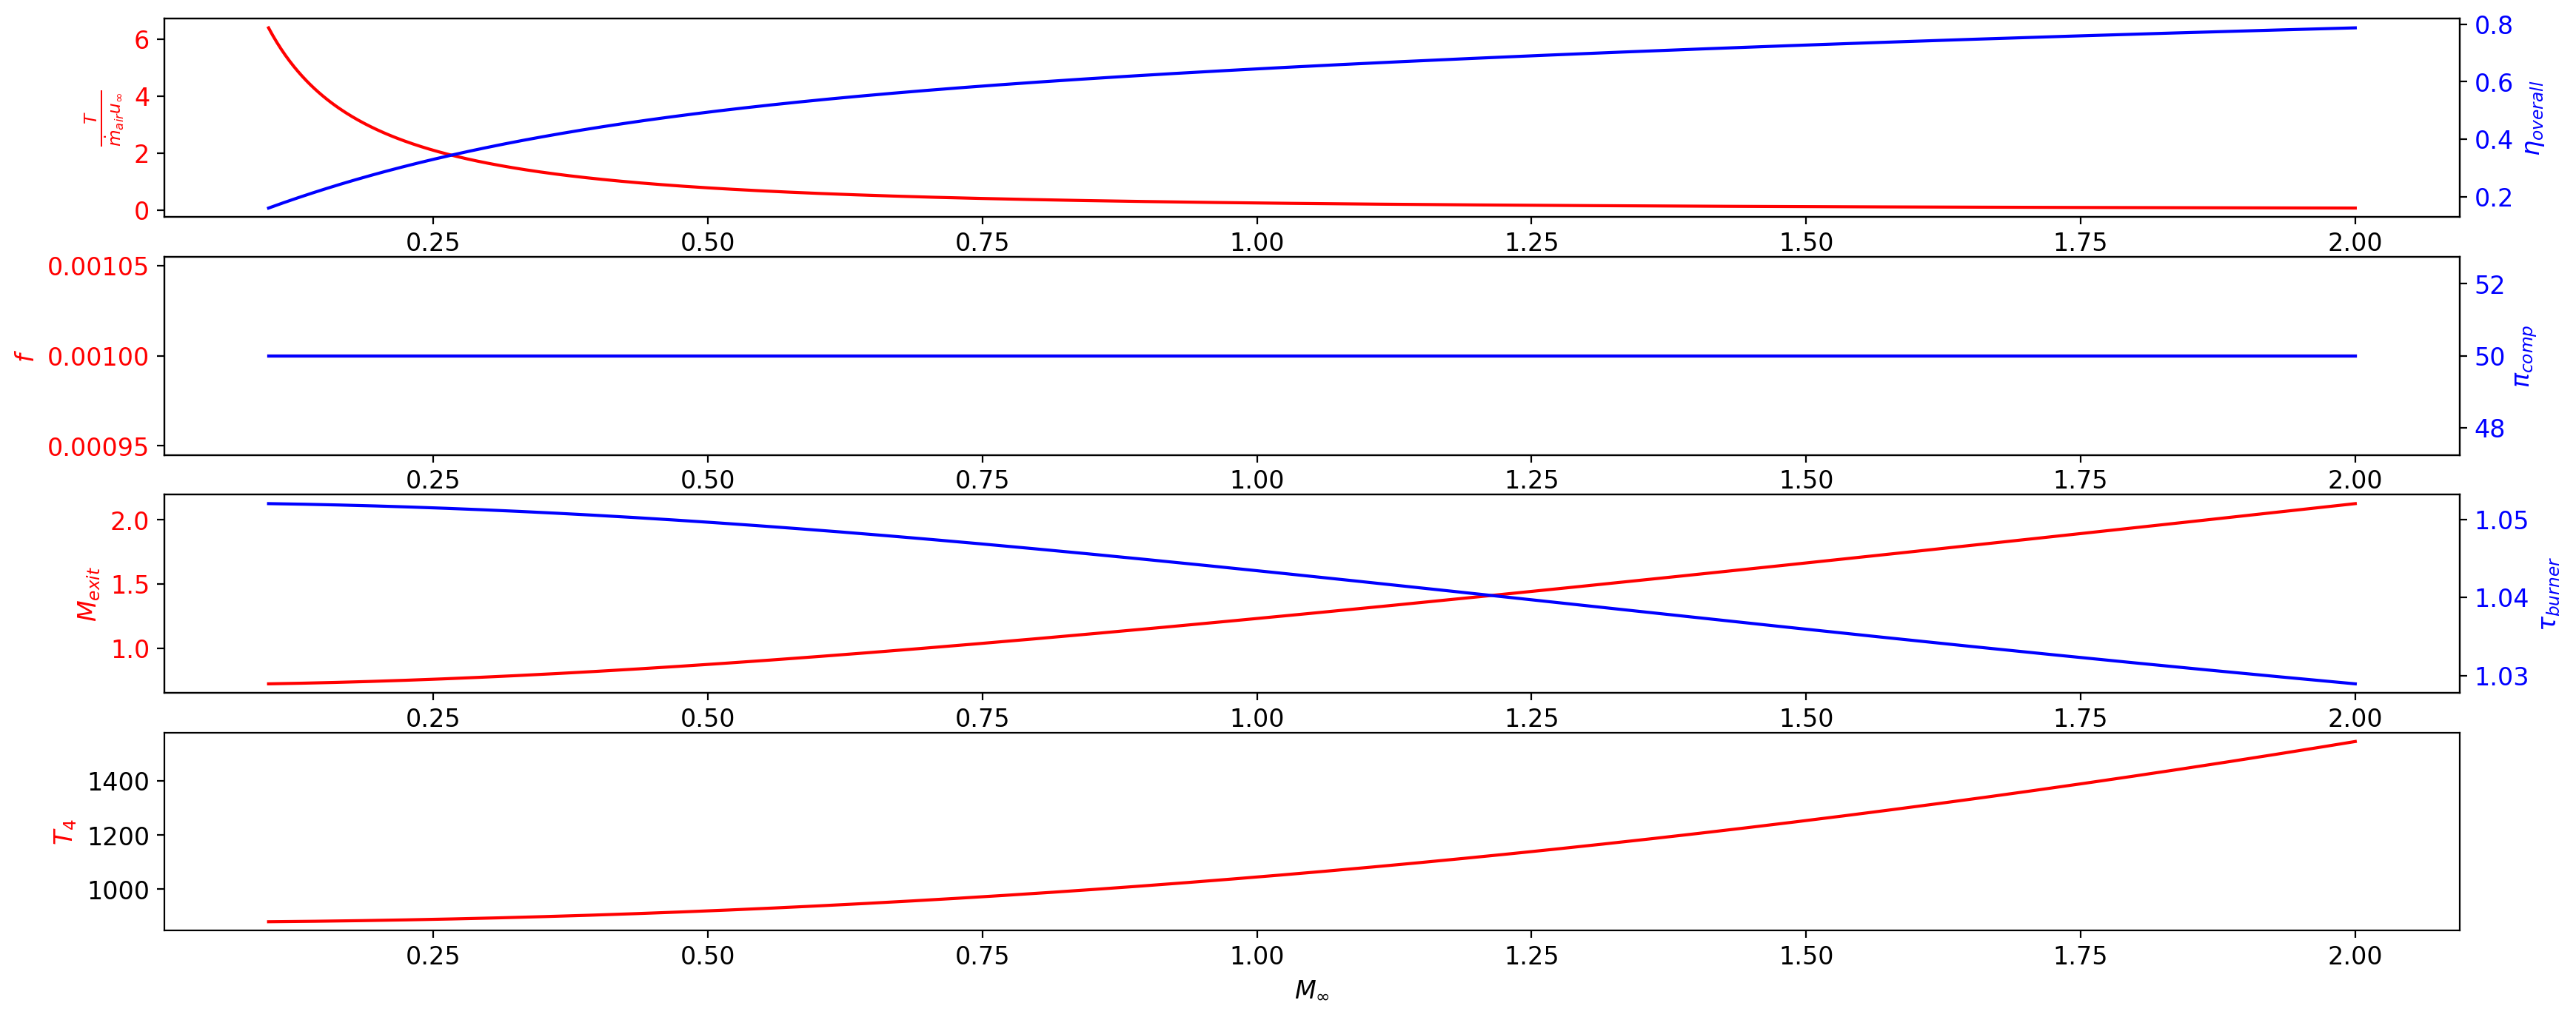

In [100]:
# Optimize the design of the turbojet for a range of inlet Mach numbers

M_inf = np.linspace(0.1, 2.0, 1000)
results = pd.DataFrame(index=M_inf, columns=['thrust', 'overall efficiency', 'f', 'pi_comp', 'T4', 'M_exit', 'tau_burner', 'success'])
tj = SimpleTurbojet(pi_comp=2)
# Initialize the initial guess for the first optimization
initial_guess = (0.001, 2.0)
for M in M_inf:
  #tj = SimpleTurbojet(M_inf=M)
  # Provide an initial guess that satisfies the constraint
  success = tj.optimize(M_inf=M, initial_guess=initial_guess)
  results.loc[M] = [tj.thrust, tj.eta_overall, tj.f, tj.pi_comp, tj.T4_K, tj.M_exit, tj.tau_burner, success]
  # Update the initial guess for the next optimization with the current optimized values
  initial_guess = (tj.f, tj.pi_comp)


fig, ax = plt.subplots(4, 1, figsize=(20, 8))
ax[0].plot(results.index, results['thrust'], label='thrust', color="red")
ax[0].set_xlabel('$M_\\infty$')
ax[0].set_ylabel('$\\frac{T}{\\dot{m}_{air}u_\\infty}$', color="red")
ax[0].tick_params(axis='y', labelcolor="red")
axy = ax[0].twinx()
axy.plot(results.index, results['overall efficiency'], label='overall efficiency', color="blue")
axy.set_ylabel('$\\eta_{overall}$', color="blue")
axy.tick_params(axis='y', labelcolor="blue")

ax[1].plot(results.index, results['f'], label='fuel to air ratio', color="red")
ax[1].set_xlabel('$M_\\infty$')
ax[1].set_ylabel('$f$', color="red")
ax[1].tick_params(axis='y', labelcolor="red")
axy = ax[1].twinx()
axy.plot(results.index, results['pi_comp'], label='compressor pressure ratio', color="blue")
axy.set_ylabel('$\pi_{comp}$', color="blue")
axy.tick_params(axis='y', labelcolor="blue")

ax[2].plot(results.index, results['M_exit'], label='nozzle exit Mach number', color="red")
ax[2].set_xlabel('$M_\\infty$')
ax[2].set_ylabel('$M_{exit}$', color="red")
ax[2].tick_params(axis='y', labelcolor="red")
axy = ax[2].twinx()
axy.plot(results.index, results['tau_burner'], label='burner total temperature ratio', color="blue")
axy.set_ylabel('$\\tau_{burner}$', color="blue")
axy.tick_params(axis='y', labelcolor="blue")

ax[3].plot(results.index, results['T4'], label='turbine inlet temperature', color="red")
ax[3].set_xlabel('$M_\\infty$')
ax[3].set_ylabel('$T_{4}$', color="red")

plt.show()

In [94]:
display(results)

,thrust,overall efficiency,f,pi_comp,T4,M_exit,tau_burner,success
0.100000,6.947793,0.174427,0.001,200.0,1286.486296,0.781228,1.034994,True
0.103808,6.661137,0.180208,0.001,200.0,1286.678829,0.781726,1.034988,True
0.107615,6.394938,0.18593,0.001,200.0,1286.878555,0.782243,1.034983,True
0.111423,6.147099,0.191596,0.001,200.0,1287.085475,0.782778,1.034977,True
0.115230,5.915799,0.197204,0.001,200.0,1287.299588,0.783332,1.034971,True
...,...,...,...,...,...,...,...,...
1.984770,1.0,0.452251,0.021868,6.936088,1799.999994,2.725909,2.120593,True
1.988577,1.0,0.450223,0.022051,6.671622,1799.99999,2.71831,2.140655,True
1.992385,1.0,0.448057,0.022242,6.405108,1799.999983,2.709991,2.162075,True
1.996192,1.0,0.445728,0.022444,6.135467,1799.999971,2.700822,2.185108,True


In [81]:
class AfterburningTurbojet(SimpleTurbojet):

  def __init__(self, M_inf: float = 0.8, eta_comp: float = 1.0,
               eta_turb: float = 1.0, pi_comp: float = 50,
               f: float = 0.025, f_ab: float = 0.01, LHV_f: float = 43.7,
               T_inf_K: float = 273) -> None:
    """Initialized an instance of the Turbojet class with afterburner given
    M_inf - float: Flight Mach Number
    eta_c - float: Compressor isentropic efficiency
    eta_t - float: Turbine isentropic efficiency
    pi_c - float: Compressor total presssure ratio
    f - float: Combustor fuel air ratio
    f_ab - float: Afterburner fuel air ratio
    LHV_f - float: Lower heating value of the fuel in MJ/kg"""
    super().__init__(M_inf, eta_comp, eta_turb, pi_comp, f, LHV_f, T_inf_K)
    self.f_ab = f_ab

  @property
  def tau_afterburner(self) -> float:
    """Afterburner total temperature ratio"""
    # Assuming constant specific heats in the afterburner for simplicity
    Tt4 = self.T4_K # Total temperature at turbine exit is T4
    return 1 + (1 + self.f) / (1 + self.f + self.f_ab) * self.f_ab * self.LHV_f / self.cp_air / Tt4

  @property
  def M_exit(self) -> float:
    """Nozzle exit Mach number with afterburner"""
    # Afterburner is at constant pressure, so pi_afterburner = 1
    return np.sqrt(2/(self.ga-1)*((self.pi_turb*self.pi_comp)**(1/self.ga1)*theta(self.M_inf, self.ga) * self.tau_afterburner - 1))

  @property
  def thrust(self) -> float:
    """Dimensionless specific thrust with afterburner"""
    return (1 + self.f + self.f_ab) * self.M_exit / self.M_inf * np.sqrt(theta(self.M_inf, self.ga)/theta(self.M_exit,self.ga)) - (1 + self.f)

  @property
  def eta_overall(self) -> float:
    """Overall efficiency with afterburner"""
    return self.thrust * self.M_inf**2 * self.ga * self.R_air * self.T_inf_K / ((self.f + self.f_ab) * self.LHV_f)

  @property
  def design(self) -> pd.Series:
    """Return a summary of the turbojet design with afterburner"""
    design_summary = super().design
    design_summary['f_ab'] = self.f_ab
    return design_summary

  @property
  def performance(self) -> pd.Series:
    """Return a summary of the turbojet performance with afterburner"""
    performance_summary = super().performance
    performance_summary['tau_afterburner'] = self.tau_afterburner
    return performance_summary

  def optimize(self, metric: Literal['efficiency', 'thrust'] = 'efficiency',
               max_turbine_inlet_temp_K: float = 1800, M_inf: Union[None, float] = None,
               initial_guess: Union[None, Tuple[float, float]] = None):
    """Optimize the afterburning turbojet design for the given metric by varying the
    total fuel to air ratio and the compressor pressure ratio"""

    # Use the default Mach number if none is specified
    self.M_inf = self.M_inf if M_inf is None else M_inf

    # Save the original fuel to air ratio and compressor pressure ratio
    org_f, org_f_ab, org_pi_comp = self.f, self.f_ab, self.pi_comp

    def fX(X):
      """Function to minimize to optimize the afterburning turbojet design"""
      self.f, self.f_ab, self.pi_comp = X
      # Ensure total fuel to air ratio is within bounds
      if self.f + self.f_ab > 0.067:
          return np.inf # Penalize designs exceeding the stoichiometric limit

      if metric == 'efficiency':
        return -self.eta_overall
      else:
        return -self.thrust

    # Use the provided initial guess if available, otherwise use the current values
    initial_guess = initial_guess if initial_guess is not None else (self.f, self.f_ab, self.pi_comp)


    # Define the constraint for turbine inlet temperature
    def turbine_inlet_temp_constraint(X):
        self.f, self.f_ab, self.pi_comp = X
        return max_turbine_inlet_temp_K - self.T4_K

    # Define the constraint for total fuel to air ratio
    def total_fuel_constraint(X):
        self.f, self.f_ab, self.pi_comp = X
        return 0.067 - (self.f + self.f_ab)

    constraints = [{'type': 'ineq', 'fun': turbine_inlet_temp_constraint},
                   {'type': 'ineq', 'fun': total_fuel_constraint}]


    result = minimize(fX, initial_guess, method='SLSQP', bounds=[(1e-3, 0.067), (0, 0.067), (1+1e-3, 200)],
                      constraints=constraints,
                      options={'maxiter': 1000}) # Increase max iterations

    if result.success:
      print(f'✅ Optimization succeeded: M_inf={self.M_inf}')
      print(f'  {metric}: {-result.fun}')
      self.f, self.f_ab, self.pi_comp = result.x
      return True
    else:
      print(f"❌ Optimization failed: M_inf={self.M_inf}")
      self.f, self.f_ab, self.pi_comp = org_f, org_f_ab, org_pi_comp
      print(result.message)
      return False

<>:33: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-406390954.py:33: SyntaxWarning: invalid escape sequence '\p'
  axy.set_ylabel('$\pi_{comp}$', color="blue")


✅ Optimization succeeded: M_inf=0.1
  efficiency: 0.17442697946504027
✅ Optimization succeeded: M_inf=0.2
  efficiency: 0.3083309476510099
✅ Optimization succeeded: M_inf=0.3
  efficiency: 0.41065079921889025
✅ Optimization succeeded: M_inf=0.4
  efficiency: 0.48904792712692907
✅ Optimization succeeded: M_inf=0.5
  efficiency: 0.5496931586606367
✅ Optimization succeeded: M_inf=0.6
  efficiency: 0.5973227469047144
✅ Optimization succeeded: M_inf=0.7
  efficiency: 0.6354485820317337
✅ Optimization succeeded: M_inf=0.7999999999999999
  efficiency: 0.666616492048923
✅ Optimization succeeded: M_inf=0.8999999999999999
  efficiency: 0.6926478527693445
✅ Optimization succeeded: M_inf=0.9999999999999999
  efficiency: 0.7148378352063411
✅ Optimization succeeded: M_inf=1.0999999999999999
  efficiency: 0.7341066112731989
✅ Optimization succeeded: M_inf=1.2
  efficiency: 0.7511099056792823
✅ Optimization succeeded: M_inf=1.3
  efficiency: 0.7663178903724267
✅ Optimization succeeded: M_inf=1.4
  eff

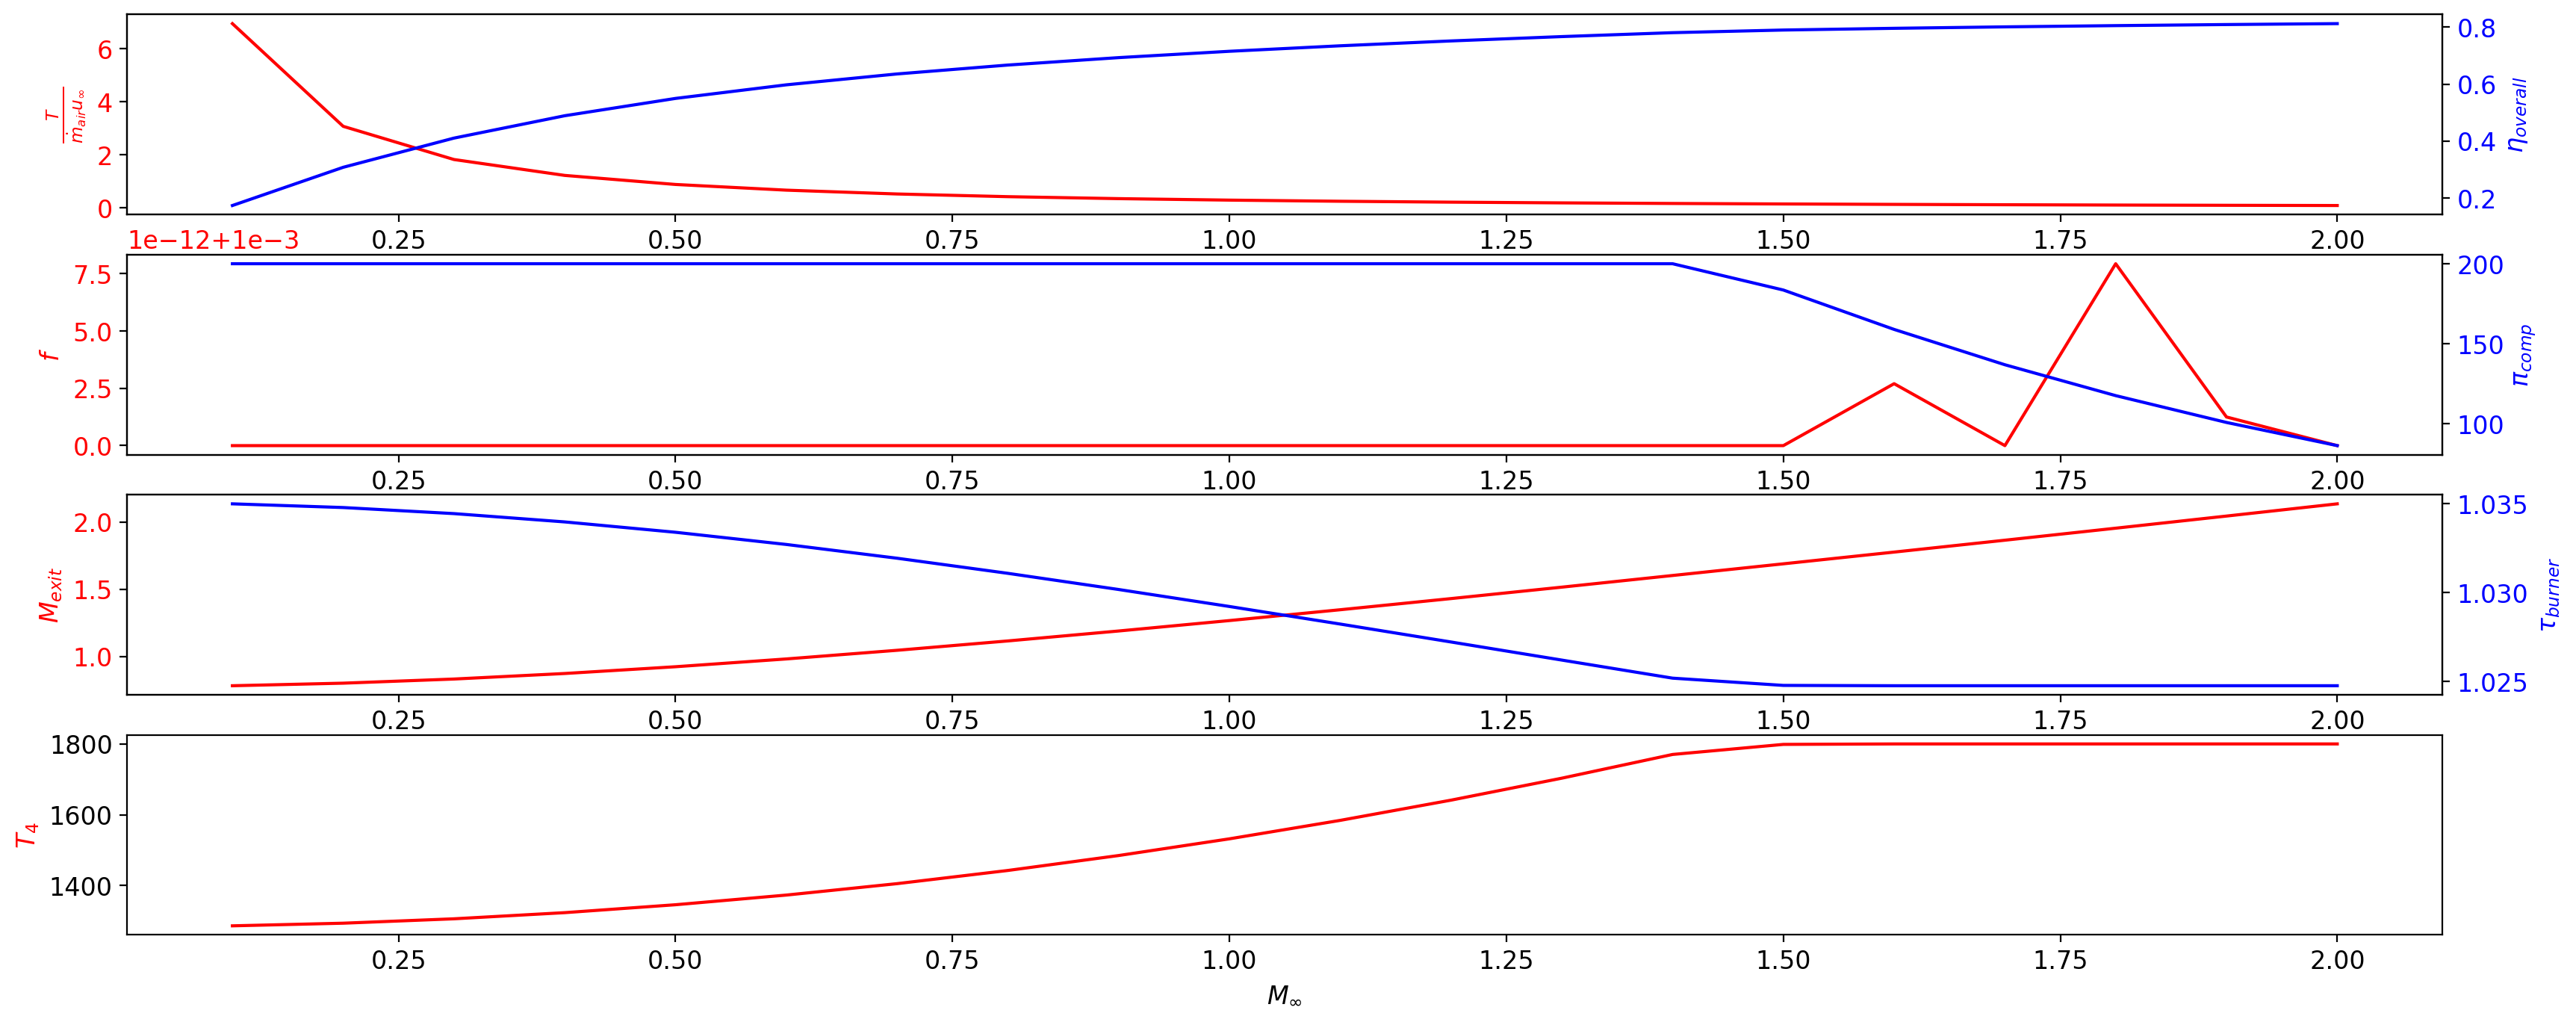

In [80]:
# Optimize the design of the turbojet for a range of inlet Mach numbers

M_inf = np.linspace(0.1, 2.0, 20)
results = pd.DataFrame(index=M_inf, columns=['thrust', 'overall efficiency', 'f', 'pi_comp', 'T4', 'M_exit', 'tau_burner', 'success'])
tj = SimpleTurbojet(pi_comp=2)
# Initialize the initial guess for the first optimization
initial_guess = (0.001, 2.0)
for M in M_inf:
  #tj = SimpleTurbojet(M_inf=M)
  # Provide an initial guess that satisfies the constraint
  success = tj.optimize(M_inf=M, initial_guess=initial_guess)
  results.loc[M] = [tj.thrust, tj.eta_overall, tj.f, tj.pi_comp, tj.T4_K, tj.M_exit, tj.tau_burner, success]
  # Update the initial guess for the next optimization with the current optimized values
  initial_guess = (tj.f, tj.pi_comp)


fig, ax = plt.subplots(4, 1, figsize=(20, 8))
ax[0].plot(results.index, results['thrust'], label='thrust', color="red")
ax[0].set_xlabel('$M_\\infty$')
ax[0].set_ylabel('$\\frac{T}{\\dot{m}_{air}u_\\infty}$', color="red")
ax[0].tick_params(axis='y', labelcolor="red")
axy = ax[0].twinx()
axy.plot(results.index, results['overall efficiency'], label='overall efficiency', color="blue")
axy.set_ylabel('$\\eta_{overall}$', color="blue")
axy.tick_params(axis='y', labelcolor="blue")

ax[1].plot(results.index, results['f'], label='fuel to air ratio', color="red")
ax[1].set_xlabel('$M_\\infty$')
ax[1].set_ylabel('$f$', color="red")
ax[1].tick_params(axis='y', labelcolor="red")
axy = ax[1].twinx()
axy.plot(results.index, results['pi_comp'], label='compressor pressure ratio', color="blue")
axy.set_ylabel('$\pi_{comp}$', color="blue")
axy.tick_params(axis='y', labelcolor="blue")

ax[2].plot(results.index, results['M_exit'], label='nozzle exit Mach number', color="red")
ax[2].set_xlabel('$M_\\infty$')
ax[2].set_ylabel('$M_{exit}$', color="red")
ax[2].tick_params(axis='y', labelcolor="red")
axy = ax[2].twinx()
axy.plot(results.index, results['tau_burner'], label='burner total temperature ratio', color="blue")
axy.set_ylabel('$\\tau_{burner}$', color="blue")
axy.tick_params(axis='y', labelcolor="blue")

ax[3].plot(results.index, results['T4'], label='turbine inlet temperature', color="red")
ax[3].set_xlabel('$M_\\infty$')
ax[3].set_ylabel('$T_{4}$', color="red")

plt.show()

<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-692769464.py:29: SyntaxWarning: invalid escape sequence '\p'
  axy.set_ylabel('$\pi_{comp}$', color="blue")


✅ Optimization succeeded: M_inf=0.1
  efficiency: 0.17442697946504027
✅ Optimization succeeded: M_inf=0.2
  efficiency: 0.3083309476510099
✅ Optimization succeeded: M_inf=0.3
  efficiency: 0.41065079921889025
✅ Optimization succeeded: M_inf=0.4
  efficiency: 0.48904792712692907
✅ Optimization succeeded: M_inf=0.5
  efficiency: 0.5496931538265042
✅ Optimization succeeded: M_inf=0.6
  efficiency: 0.5973227242871934
✅ Optimization succeeded: M_inf=0.7
  efficiency: 0.635448577063824
✅ Optimization succeeded: M_inf=0.7999999999999999
  efficiency: 0.666616492048923
✅ Optimization succeeded: M_inf=0.8999999999999999
  efficiency: 0.6926478527693445
✅ Optimization succeeded: M_inf=0.9999999999999999
  efficiency: 0.7148378326310318
✅ Optimization succeeded: M_inf=1.0999999999999999
  efficiency: 0.7341066112731989
✅ Optimization succeeded: M_inf=1.2
  efficiency: 0.7511099028904482
✅ Optimization succeeded: M_inf=1.3
  efficiency: 0.7663178903724267
✅ Optimization succeeded: M_inf=1.4
  effi

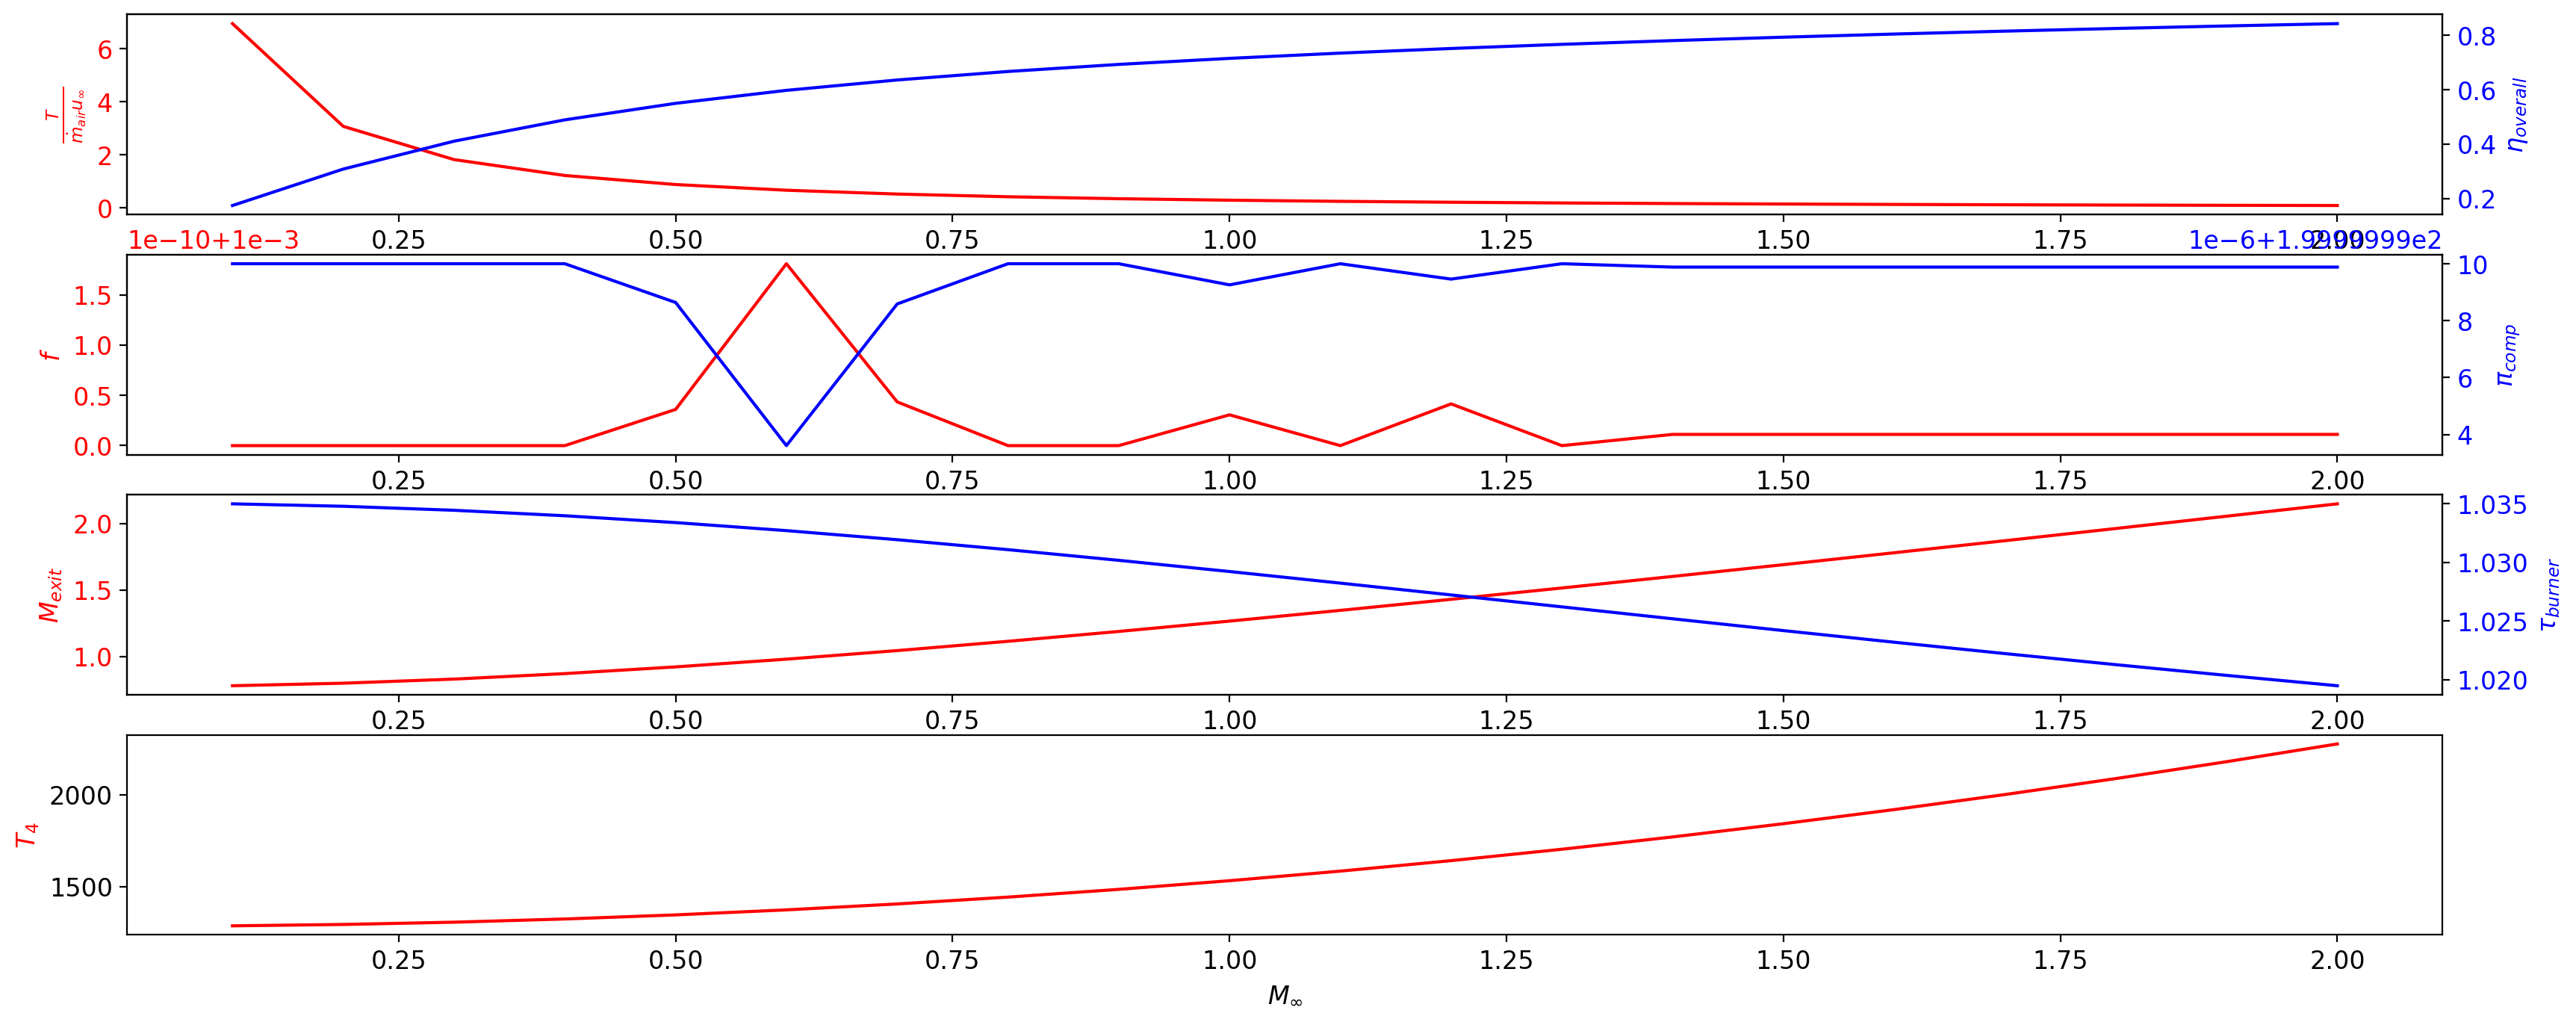

In [77]:
# Optimize the design of the turbojet for a range of inlet Mach numbers

M_inf = np.linspace(0.1, 2.0, 20)
results = pd.DataFrame(index=M_inf, columns=['thrust', 'overall efficiency', 'f', 'pi_comp', 'T4', 'M_exit', 'tau_burner', 'success'])
tj = SimpleTurbojet(pi_comp=2)
for M in M_inf:
  #tj = SimpleTurbojet(M_inf=M)
  # Provide an initial guess that satisfies the constraint
  initial_guess = (0.001, 2.0) # Start with a low f and pi_comp
  success = tj.optimize(M_inf=M, initial_guess=initial_guess)
  results.loc[M] = [tj.thrust, tj.eta_overall, tj.f, tj.pi_comp, tj.T4_K, tj.M_exit, tj.tau_burner, success]

fig, ax = plt.subplots(4, 1, figsize=(20, 8))
ax[0].plot(results.index, results['thrust'], label='thrust', color="red")
ax[0].set_xlabel('$M_\\infty$')
ax[0].set_ylabel('$\\frac{T}{\\dot{m}_{air}u_\\infty}$', color="red")
ax[0].tick_params(axis='y', labelcolor="red")
axy = ax[0].twinx()
axy.plot(results.index, results['overall efficiency'], label='overall efficiency', color="blue")
axy.set_ylabel('$\\eta_{overall}$', color="blue")
axy.tick_params(axis='y', labelcolor="blue")

ax[1].plot(results.index, results['f'], label='fuel to air ratio', color="red")
ax[1].set_xlabel('$M_\\infty$')
ax[1].set_ylabel('$f$', color="red")
ax[1].tick_params(axis='y', labelcolor="red")
axy = ax[1].twinx()
axy.plot(results.index, results['pi_comp'], label='compressor pressure ratio', color="blue")
axy.set_ylabel('$\pi_{comp}$', color="blue")
axy.tick_params(axis='y', labelcolor="blue")

ax[2].plot(results.index, results['M_exit'], label='nozzle exit Mach number', color="red")
ax[2].set_xlabel('$M_\\infty$')
ax[2].set_ylabel('$M_{exit}$', color="red")
ax[2].tick_params(axis='y', labelcolor="red")
axy = ax[2].twinx()
axy.plot(results.index, results['tau_burner'], label='burner total temperature ratio', color="blue")
axy.set_ylabel('$\\tau_{burner}$', color="blue")
axy.tick_params(axis='y', labelcolor="blue")

ax[3].plot(results.index, results['T4'], label='turbine inlet temperature', color="red")
ax[3].set_xlabel('$M_\\infty$')
ax[3].set_ylabel('$T_{4}$', color="red")

plt.show()

<>:29: SyntaxWarning: invalid escape sequence '\p'
<>:29: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-692769464.py:29: SyntaxWarning: invalid escape sequence '\p'
  axy.set_ylabel('$\pi_{comp}$', color="blue")


✅ Optimization succeeded: M_inf=0.1
  efficiency: 0.17442697946504027
✅ Optimization succeeded: M_inf=0.2
  efficiency: 0.3083309476510099
✅ Optimization succeeded: M_inf=0.3
  efficiency: 0.41065079921889025
✅ Optimization succeeded: M_inf=0.4
  efficiency: 0.48904792712692907
✅ Optimization succeeded: M_inf=0.5
  efficiency: 0.5496931538265042
✅ Optimization succeeded: M_inf=0.6
  efficiency: 0.5973227242871934
✅ Optimization succeeded: M_inf=0.7
  efficiency: 0.635448577063824
✅ Optimization succeeded: M_inf=0.7999999999999999
  efficiency: 0.666616492048923
✅ Optimization succeeded: M_inf=0.8999999999999999
  efficiency: 0.6926478527693445
✅ Optimization succeeded: M_inf=0.9999999999999999
  efficiency: 0.7148378326310318
✅ Optimization succeeded: M_inf=1.0999999999999999
  efficiency: 0.7341066112731989
✅ Optimization succeeded: M_inf=1.2
  efficiency: 0.7511099028904482
✅ Optimization succeeded: M_inf=1.3
  efficiency: 0.7663178903724267
✅ Optimization succeeded: M_inf=1.4
  effi

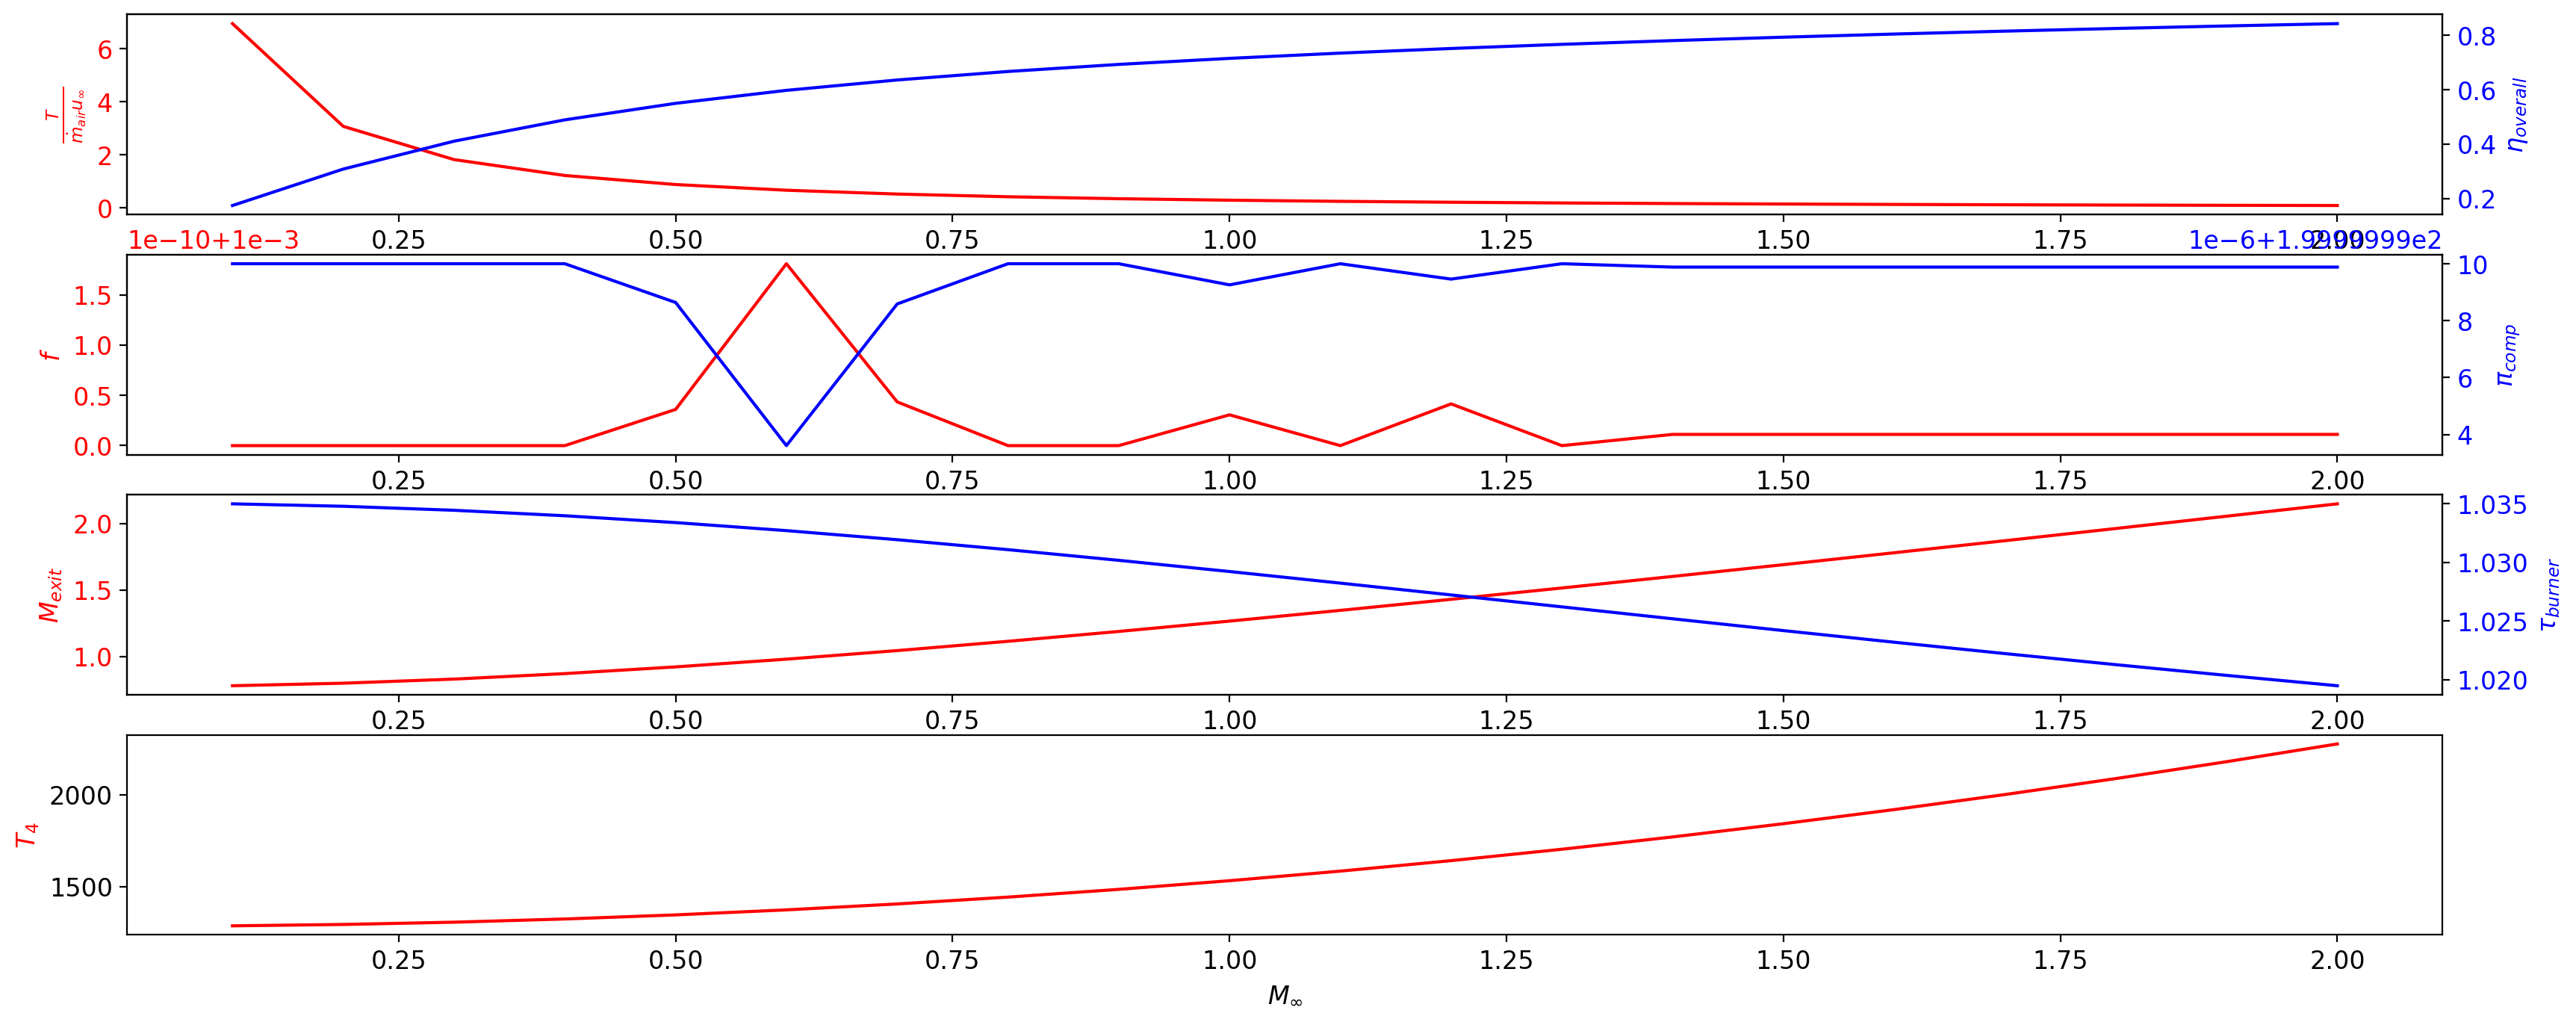

In [75]:
# Optimize the design of the turbojet for a range of inlet Mach numbers

M_inf = np.linspace(0.1, 2.0, 20)
results = pd.DataFrame(index=M_inf, columns=['thrust', 'overall efficiency', 'f', 'pi_comp', 'T4', 'M_exit', 'tau_burner', 'success'])
tj = SimpleTurbojet(pi_comp=2)
for M in M_inf:
  #tj = SimpleTurbojet(M_inf=M)
  # Provide an initial guess that satisfies the constraint
  initial_guess = (0.001, 2.0) # Start with a low f and pi_comp
  success = tj.optimize(M_inf=M, initial_guess=initial_guess)
  results.loc[M] = [tj.thrust, tj.eta_overall, tj.f, tj.pi_comp, tj.T4_K, tj.M_exit, tj.tau_burner, success]

fig, ax = plt.subplots(4, 1, figsize=(20, 8))
ax[0].plot(results.index, results['thrust'], label='thrust', color="red")
ax[0].set_xlabel('$M_\\infty$')
ax[0].set_ylabel('$\\frac{T}{\\dot{m}_{air}u_\\infty}$', color="red")
ax[0].tick_params(axis='y', labelcolor="red")
axy = ax[0].twinx()
axy.plot(results.index, results['overall efficiency'], label='overall efficiency', color="blue")
axy.set_ylabel('$\\eta_{overall}$', color="blue")
axy.tick_params(axis='y', labelcolor="blue")

ax[1].plot(results.index, results['f'], label='fuel to air ratio', color="red")
ax[1].set_xlabel('$M_\\infty$')
ax[1].set_ylabel('$f$', color="red")
ax[1].tick_params(axis='y', labelcolor="red")
axy = ax[1].twinx()
axy.plot(results.index, results['pi_comp'], label='compressor pressure ratio', color="blue")
axy.set_ylabel('$\pi_{comp}$', color="blue")
axy.tick_params(axis='y', labelcolor="blue")

ax[2].plot(results.index, results['M_exit'], label='nozzle exit Mach number', color="red")
ax[2].set_xlabel('$M_\\infty$')
ax[2].set_ylabel('$M_{exit}$', color="red")
ax[2].tick_params(axis='y', labelcolor="red")
axy = ax[2].twinx()
axy.plot(results.index, results['tau_burner'], label='burner total temperature ratio', color="blue")
axy.set_ylabel('$\\tau_{burner}$', color="blue")
axy.tick_params(axis='y', labelcolor="blue")

ax[3].plot(results.index, results['T4'], label='turbine inlet temperature', color="red")
ax[3].set_xlabel('$M_\\infty$')
ax[3].set_ylabel('$T_{4}$', color="red")

plt.show()